#                FINAL SCRIPT OF IST 718 Group 1

# Import Required Packages:

In [54]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
!pip install plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import datetime 
import calendar 
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

You should consider upgrading via the 'c:\anaconda3\python.exe -m pip install --upgrade pip' command.


# Load Data:

In [55]:
hotel_bookings=pd.read_csv("hotel_bookings.csv")
                           
# Printing first 10 records of hotel_bookings                           
hotel_bookings.head(10) 

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


# Data Cleaning:

In [56]:
# Number of Null Values in data:
hotel_bookings.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [57]:
# Replacing null values in 'children' column with '0' because average of the same column is nearly '0'
hotel_bookings['children'].fillna(0,inplace=True)

# Replacing null values in 'country' column with 'Unknown' text
hotel_bookings['country'].fillna('Unknown',inplace=True)


In [58]:
# Converting data types to category to reduce data frame size

hotel_bookings['hotel']=hotel_bookings['hotel'].astype('category')
hotel_bookings['is_canceled']=hotel_bookings['is_canceled'].astype('category')
hotel_bookings['meal']=hotel_bookings['meal'].astype('category')
hotel_bookings['country']=hotel_bookings['country'].astype('category')
hotel_bookings['market_segment']=hotel_bookings['market_segment'].astype('category')
hotel_bookings['distribution_channel']=hotel_bookings['distribution_channel'].astype('category')
hotel_bookings['is_repeated_guest']=hotel_bookings['is_repeated_guest'].astype('category')
hotel_bookings['reserved_room_type']=hotel_bookings['reserved_room_type'].astype('category')
hotel_bookings['deposit_type']=hotel_bookings['deposit_type'].astype('category')
hotel_bookings['customer_type']=hotel_bookings['customer_type'].astype('category')
hotel_bookings['required_car_parking_spaces']=hotel_bookings['required_car_parking_spaces'].astype('category')
hotel_bookings['total_of_special_requests']=hotel_bookings['total_of_special_requests'].astype('category')
hotel_bookings['reservation_status']=hotel_bookings['reservation_status'].astype('category')
hotel_bookings['reservation_status_date']=hotel_bookings['reservation_status_date'].astype('datetime64[ns]')
hotel_bookings['children']=hotel_bookings['children'].astype('int64')
hotel_bookings['stays_in_weekend_nights']=hotel_bookings['stays_in_weekend_nights'].astype('category')
hotel_bookings['stays_in_week_nights']=hotel_bookings['stays_in_week_nights'].astype('category')
hotel_bookings['assigned_room_type']=hotel_bookings['assigned_room_type'].astype('category')
hotel_bookings['arrival_date_month']=hotel_bookings['arrival_date_month'].astype('category')

In [59]:
# Checking all the changes till now
hotel_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null category
is_canceled                       119390 non-null category
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null category
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null category
stays_in_week_nights              119390 non-null category
adults                            119390 non-null int64
children                          119390 non-null int64
babies                            119390 non-null int64
meal                              119390 non-null category
country                           119390 non-null category
market_segment                    119390 non-null category
distribution_channel     

In [60]:
# Number of rows with children, adults, babies = 0 , in short rows with no guests
hotel_bookings[(hotel_bookings['children']==0) & (hotel_bookings['adults']==0) & (hotel_bookings['babies']==0)]['hotel'].count()

180

In [61]:
# Removing rows with children, adults, babies = 0 , in short rows with no guests
hotel_bookings=hotel_bookings.drop(hotel_bookings[(hotel_bookings['children']==0) & (hotel_bookings['adults']==0) & (hotel_bookings['babies']==0)].index)

In [62]:
# Converting Day, Month, Year into a single arrival date for ease of analysis

month_number={'January':1,
             'February':2,
             'March':3,
             'April':4,
             'May':5,
             'June':6,
             'July':7,
             'August':8,
             'September':9,
             'October':10,
             'November':11,
             'December':12}

hotel_bookings['arrival_date_month_number']=hotel_bookings['arrival_date_month'].apply(lambda x:month_number[x])
hotel_bookings['arrival_date_month_number']=hotel_bookings['arrival_date_month_number'].astype('category')

hotel_bookings['date_of_arrival']=pd.to_datetime(hotel_bookings['arrival_date_year'].astype(str)+hotel_bookings['arrival_date_month_number'].astype(str)+hotel_bookings['arrival_date_day_of_month'].astype(str),format="%Y%m%d")

This made us realise that there are 1 day stays too! Which we have found below.

In [63]:
# Number of one day stays
hotel_bookings[(hotel_bookings['stays_in_week_nights']==0) & (hotel_bookings['stays_in_weekend_nights']==0)]['hotel'].count()

645

In [64]:
# Setting day of leaving = None for rows where there is no check out. This means these people 'Cancelled' or 'No Show'.
hotel_bookings.loc[hotel_bookings['reservation_status']!='Check-Out','day_of_leaving']=None

In [65]:
# Creating a column for 'total_nigt_stays' for number of night stays
hotel_bookings['total_night_stays']=hotel_bookings['stays_in_week_nights'].astype(int)+hotel_bookings['stays_in_weekend_nights'].astype(int)

In [66]:
# Creating a categorical column for 'One_day_stay' signifying 'Yes' or 'No'
hotel_bookings.loc[(hotel_bookings['reservation_status']=='Check-Out')&(hotel_bookings['total_night_stays']==0),'One_day_stay']='Yes'
hotel_bookings['One_day_stay']=hotel_bookings['One_day_stay'].astype('category')

In [67]:
# Checking number of cancelled and uncancelled bookings
# Value indicating if the booking was canceled (1) or not (0)
hotel_bookings['is_canceled'].value_counts()

0    75011
1    44199
Name: is_canceled, dtype: int64

# Exploratory Analysis:

In [68]:
# Number of rows:
print(hotel_bookings['hotel'].count())

# Number of Columns:
print(len(hotel_bookings.columns))

# Column Names:
hotel_bookings.columns


119210
37


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date',
       'arrival_date_month_number', 'date_of_arrival', 'day_of_leaving',
       'total_night_stays', 'One_day_stay'],
      dtype='object')

In [69]:
# Total bookings per market segment (incl. canceled)

segments=hotel_bookings["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()


([<matplotlib.patches.Wedge at 0x228c4c9d7c8>,
 [Text(-0.9570941673166501, -0.5421906997435941, 'City Hotel'),
  Text(0.957094218080203, 0.5421906101339686, 'Resort Hotel')],
 [Text(-0.5220513639909, -0.29574038167832406, '66.4%'),
  Text(0.5220513916801106, 0.29574033280034645, '33.6%')])

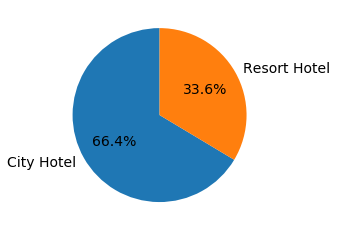

In [70]:
# Total bookings by hotel type

plt.pie(hotel_bookings['hotel'].value_counts().tolist(),
        labels=hotel_bookings['hotel'].value_counts().index.tolist(), autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 14})

In [71]:
# Total percent of bookings cancelled by hotel type

hotel_bookings['hotel']=hotel_bookings['hotel'].astype('object')
hotel_bookings['is_canceled']=hotel_bookings['is_canceled'].astype('int64')

total_cancelations = hotel_bookings["is_canceled"].sum()
rh_cancelations = hotel_bookings.loc[hotel_bookings["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = hotel_bookings.loc[hotel_bookings["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / hotel_bookings.shape[0] * 100
rh_rel_cancel = rh_cancelations / hotel_bookings.loc[hotel_bookings["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / hotel_bookings.loc[hotel_bookings["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")


Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


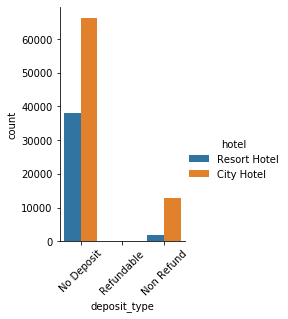

In [149]:
# Analysis of Payment type

hotel_bookings['hotel']=hotel_bookings['hotel'].astype('object')
hotel_bookings['deposit_type']=hotel_bookings['deposit_type'].astype('object')


payment_analysis = sns.catplot(x="deposit_type", hue="hotel", 
                data=hotel_bookings, kind="count",
                height=4, aspect=.7)
payment_analysis.set_xticklabels(rotation=45)

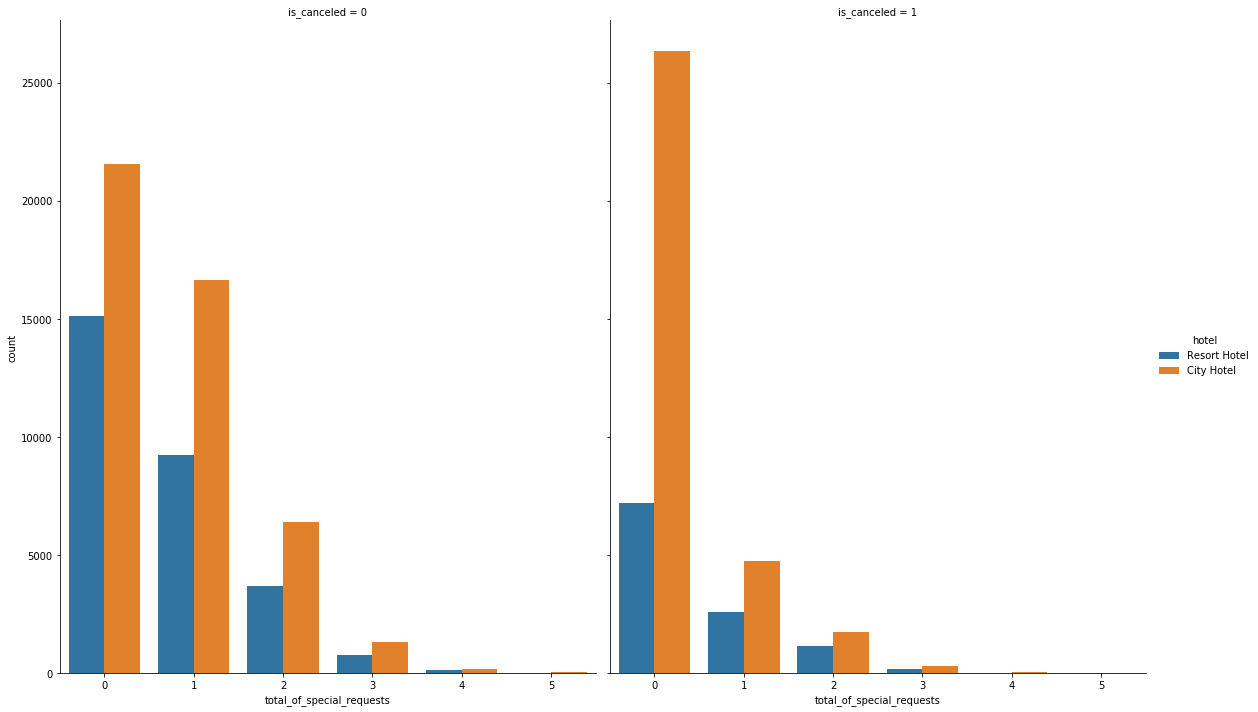

In [73]:
# Special Request Analysis

Special_request_plot = sns.catplot(x='total_of_special_requests', hue="hotel", col="is_canceled",
                data=hotel_bookings, kind="count",
                height=10, aspect=.8)

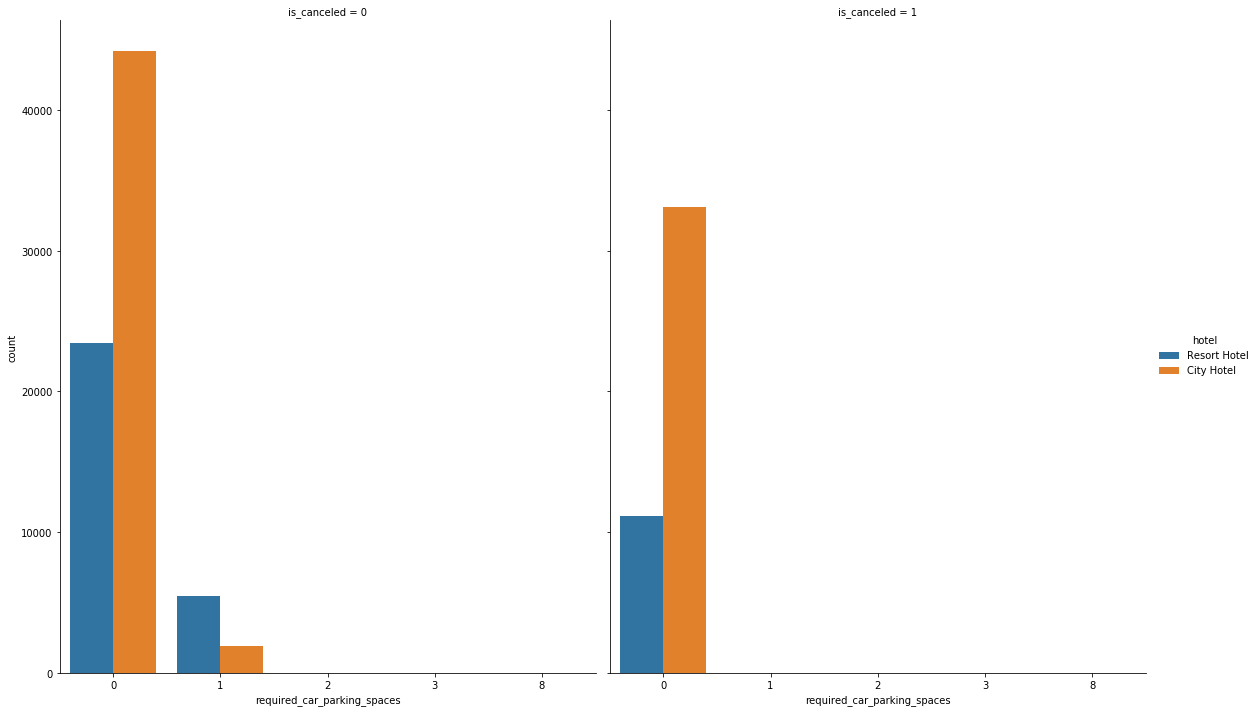

In [74]:
# Special request: car parking space analysis

plot6 = sns.catplot(x="required_car_parking_spaces", hue="hotel", col="is_canceled",
                data=hotel_bookings, kind="count",
                height=10, aspect=.8)

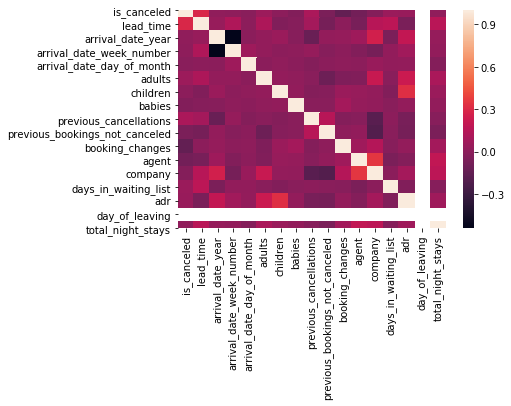

In [75]:
# Correlation heatmap

corr = hotel_bookings.corr()
sns.heatmap(corr)

# Feature Engineering:

In [76]:
# Defining the schema for spark dataframe
mySchema = StructType([ StructField("is_canceled", IntegerType(), True)\
                       ,StructField("hotel", StringType(), True)\
                       ,StructField("lead_time", ShortType(), True)\
                       ,StructField("arrival_date_year", ShortType(), True)\
                       ,StructField("arrival_date_month", StringType(), True)\
                       ,StructField("arrival_date_week_number", ByteType(), True)\
                       ,StructField("arrival_date_day_of_month", ByteType(), True)\
                       ,StructField("stays_in_weekend_nights", ByteType(), True)\
                       ,StructField("stays_in_week_nights", ByteType(), True)\
                       ,StructField("adults", ByteType(), True)\
                       ,StructField("children", ByteType(), True)\
                       ,StructField("babies", ByteType(), True)\
                       ,StructField("meal", StringType(), True)\
                       ,StructField("country", StringType(), True)\
                       ,StructField("market_segment", StringType(), True)\
                       ,StructField("distribution_channel", StringType(), True)\
                       ,StructField("is_repeated_guest", ByteType(), True)\
                       ,StructField("previous_cancellations", ByteType(), True)\
                       ,StructField("previous_bookings_not_canceled", ByteType(), True)\
                       ,StructField("reserved_room_type", StringType(), True)\
                       ,StructField("assigned_room_type", StringType(), True)\
                       ,StructField("booking_changes", ByteType(), True)\
                       ,StructField("deposit_type", StringType(), True)\
                       ,StructField("agent", StringType(), True)\
                       ,StructField("company", StringType(), True)\
                       ,StructField("days_in_waiting_list", ShortType(), True)\
                       ,StructField("customer_type", StringType(), True)\
                       ,StructField("adr", FloatType(), True)\
                       ,StructField("required_car_parking_spaces", ByteType(), True)\
                       ,StructField("total_of_special_requests", ByteType(), True)\
                       ,StructField("reservation_status", StringType(), True)\
                       ,StructField("reservation_status_date", DateType(), True)\
                       ,StructField("arrival_date_month_number", ByteType(), True)\
                       ,StructField("day_of_leaving", StringType(), True)\
                       ,StructField("total_night_stays", ByteType(), True)\
                       ,StructField("One_day_stay", StringType(), True)\
                       ])

# Defining necessary columns for spark dataframe
columns = hotel_bookings[['is_canceled','hotel','lead_time','arrival_date_year','arrival_date_month',
                          'arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',
                          'stays_in_week_nights','adults','children','babies','meal','country','market_segment',
                          'distribution_channel','is_repeated_guest','previous_cancellations',
                          'previous_bookings_not_canceled','reserved_room_type','assigned_room_type','booking_changes',
                          'deposit_type','agent','company','days_in_waiting_list','customer_type','adr',
                          'required_car_parking_spaces','total_of_special_requests','reservation_status',
                          'reservation_status_date','arrival_date_month_number','day_of_leaving','total_night_stays','One_day_stay']]

In [77]:
# Creating spark dataframe
Hotel_Bookings=spark.createDataFrame(columns,mySchema)
Hotel_Bookings.printSchema()

root
 |-- is_canceled: integer (nullable = true)
 |-- hotel: string (nullable = true)
 |-- lead_time: short (nullable = true)
 |-- arrival_date_year: short (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: byte (nullable = true)
 |-- arrival_date_day_of_month: byte (nullable = true)
 |-- stays_in_weekend_nights: byte (nullable = true)
 |-- stays_in_week_nights: byte (nullable = true)
 |-- adults: byte (nullable = true)
 |-- children: byte (nullable = true)
 |-- babies: byte (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: byte (nullable = true)
 |-- previous_cancellations: byte (nullable = true)
 |-- previous_bookings_not_canceled: byte (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: 

**Carrying out chi-square test followed by Cramers V test to check correlation between 2 categorical variables**

**Run code below till next markdown**

In [78]:
cramers={}

In [79]:
indexer = StringIndexer(inputCol="adults", outputCol="adultsIndex")
assembler=VectorAssembler(inputCols=['adultsIndex'],outputCol='adultsVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [80]:
r=ChiSquareTest.test(Hotel_Bookings,'adultsVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['adults']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))


pValues: [0.0]
degreesOfFreedom: [13]
statistics: [884.9633855462503]


In [81]:
indexer = StringIndexer(inputCol="market_segment", outputCol="market_segmentIndex")
assembler=VectorAssembler(inputCols=['market_segmentIndex'],outputCol='market_segmentVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)


In [82]:
r=ChiSquareTest.test(Hotel_Bookings,'market_segmentVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['market_segment']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [7]
statistics: [8498.74599699494]


In [83]:
indexer = StringIndexer(inputCol="arrival_date_month", outputCol="arrival_date_monthIndex")
assembler=VectorAssembler(inputCols=['arrival_date_monthIndex'],outputCol='arrival_date_monthVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [84]:
r=ChiSquareTest.test(Hotel_Bookings,'arrival_date_monthVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['arrival_date_month']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [11]
statistics: [582.2227667379334]


In [85]:
indexer = StringIndexer(inputCol="arrival_date_week_number", outputCol="arrival_date_week_numberIndex")
assembler=VectorAssembler(inputCols=['arrival_date_week_numberIndex'],outputCol='arrival_date_week_numberVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [86]:
r=ChiSquareTest.test(Hotel_Bookings,'arrival_date_week_numberVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['arrival_date_week_number']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [52]
statistics: [1123.357237638491]


In [87]:
indexer = StringIndexer(inputCol="stays_in_weekend_nights", outputCol="stays_in_weekend_nightsIndex")
assembler=VectorAssembler(inputCols=['stays_in_weekend_nightsIndex'],outputCol='stays_in_weekend_nightsVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [88]:
r=ChiSquareTest.test(Hotel_Bookings,'stays_in_weekend_nightsVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['stays_in_weekend_nights']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [1.1102230246251565e-16]
degreesOfFreedom: [16]
statistics: [112.55286008901929]


In [89]:
indexer = StringIndexer(inputCol="stays_in_week_nights", outputCol="stays_in_week_nightsIndex")
assembler=VectorAssembler(inputCols=['stays_in_week_nightsIndex'],outputCol='stays_in_week_nightsVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [90]:
r=ChiSquareTest.test(Hotel_Bookings,'stays_in_week_nightsVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['stays_in_week_nights']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [32]
statistics: [1691.0593222601146]


In [91]:
indexer = StringIndexer(inputCol="children", outputCol="childrenIndex")
assembler=VectorAssembler(inputCols=['childrenIndex'],outputCol='childrenVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [92]:
r=ChiSquareTest.test(Hotel_Bookings,'childrenVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['children']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [4]
statistics: [98.72358870301257]


In [93]:
indexer = StringIndexer(inputCol="babies", outputCol="babiesIndex")
assembler=VectorAssembler(inputCols=['babiesIndex'],outputCol='babiesVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [94]:
r=ChiSquareTest.test(Hotel_Bookings,'babiesVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['babies']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [4]
statistics: [141.41277777666724]


In [95]:
indexer = StringIndexer(inputCol="meal", outputCol="mealIndex")
assembler=VectorAssembler(inputCols=['mealIndex'],outputCol='mealVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [96]:
r=ChiSquareTest.test(Hotel_Bookings,'mealVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['meal']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [4]
statistics: [305.0232950685645]


In [97]:
indexer = StringIndexer(inputCol="country", outputCol="countryIndex")
assembler=VectorAssembler(inputCols=['countryIndex'],outputCol='countryVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [98]:
r=ChiSquareTest.test(Hotel_Bookings,'countryVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['country']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [177]
statistics: [15620.282198022387]


In [99]:
indexer = StringIndexer(inputCol="distribution_channel", outputCol="distribution_channelIndex")
assembler=VectorAssembler(inputCols=['distribution_channelIndex'],outputCol='distribution_channelVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [100]:
r=ChiSquareTest.test(Hotel_Bookings,'distribution_channelVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['distribution_channel']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [4]
statistics: [3741.79141091977]


In [101]:
indexer = StringIndexer(inputCol="is_repeated_guest", outputCol="is_repeated_guestIndex")
assembler=VectorAssembler(inputCols=['is_repeated_guestIndex'],outputCol='is_repeated_guestVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [102]:
r=ChiSquareTest.test(Hotel_Bookings,'is_repeated_guestVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['is_repeated_guest']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))


pValues: [0.0]
degreesOfFreedom: [1]
statistics: [836.0555307067813]


In [103]:
indexer = StringIndexer(inputCol="previous_cancellations", outputCol="previous_cancellationsIndex")
assembler=VectorAssembler(inputCols=['previous_cancellationsIndex'],outputCol='previous_cancellationsVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [104]:
r=ChiSquareTest.test(Hotel_Bookings,'previous_cancellationsVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['previous_cancellation']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [14]
statistics: [9260.342833187613]


In [105]:
indexer = StringIndexer(inputCol="reserved_room_type", outputCol="reserved_room_typeIndex")
assembler=VectorAssembler(inputCols=['reserved_room_typeIndex'],outputCol='reserved_room_typeVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [106]:
r=ChiSquareTest.test(Hotel_Bookings,'reserved_room_typeVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['reserved_room_type']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [8]
statistics: [631.2516158476984]


In [107]:
indexer = StringIndexer(inputCol="booking_changes", outputCol="booking_changesIndex")
assembler=VectorAssembler(inputCols=['booking_changesIndex'],outputCol='booking_changesVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [108]:
r=ChiSquareTest.test(Hotel_Bookings,'booking_changesVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['booking_changes']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [18]
statistics: [4186.2117768489115]


In [109]:
indexer = StringIndexer(inputCol="deposit_type", outputCol="deposit_typeIndex")
assembler=VectorAssembler(inputCols=['deposit_typeIndex'],outputCol='deposit_typeVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [110]:
r=ChiSquareTest.test(Hotel_Bookings,'deposit_typeVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['deposit_type']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [2]
statistics: [27641.39714597139]


In [111]:
indexer = StringIndexer(inputCol="agent", outputCol="agentIndex")
assembler=VectorAssembler(inputCols=['agentIndex'],outputCol='agentVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [112]:
r=ChiSquareTest.test(Hotel_Bookings,'agentVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['agent']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [333]
statistics: [17761.786291033997]


In [113]:
indexer = StringIndexer(inputCol="company", outputCol="companyIndex")
assembler=VectorAssembler(inputCols=['companyIndex'],outputCol='companyVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [114]:
r=ChiSquareTest.test(Hotel_Bookings,'companyVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['company']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [348]
statistics: [2361.2175952813077]


In [115]:
indexer = StringIndexer(inputCol="days_in_waiting_list", outputCol="days_in_waiting_listIndex")
assembler=VectorAssembler(inputCols=['days_in_waiting_listIndex'],outputCol='days_in_waiting_listVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [116]:
r=ChiSquareTest.test(Hotel_Bookings,'days_in_waiting_listVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['days_in_waiting_list']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [126]
statistics: [3173.5784683108445]


In [117]:
indexer = StringIndexer(inputCol="customer_type", outputCol="customer_typeIndex")
assembler=VectorAssembler(inputCols=['customer_typeIndex'],outputCol='customer_typeVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [118]:
r=ChiSquareTest.test(Hotel_Bookings,'customer_typeVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['customer_type']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [3]
statistics: [2224.970184990408]


In [119]:
indexer = StringIndexer(inputCol="required_car_parking_spaces", outputCol="required_car_parking_spacesIndex")
assembler=VectorAssembler(inputCols=['required_car_parking_spacesIndex'],outputCol='required_car_parking_spacesVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [120]:
r=ChiSquareTest.test(Hotel_Bookings,'required_car_parking_spacesVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['required_car_parking_spaces']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [4]
statistics: [4654.939951610829]


In [121]:
indexer = StringIndexer(inputCol="total_of_special_requests", outputCol="total_of_special_requestsIndex")
assembler=VectorAssembler(inputCols=['total_of_special_requestsIndex'],outputCol='total_of_special_requestsVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [122]:
r=ChiSquareTest.test(Hotel_Bookings,'total_of_special_requestsVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['total_of_special_requests']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [5]
statistics: [8408.589662195596]


In [123]:
indexer = StringIndexer(inputCol="total_night_stays", outputCol="total_night_staysIndex")
assembler=VectorAssembler(inputCols=['total_night_staysIndex'],outputCol='total_night_staysVector')
pipeline = Pipeline(stages=[indexer,assembler])
Hotel_Bookings=pipeline.fit(Hotel_Bookings).transform(Hotel_Bookings)

In [124]:
r=ChiSquareTest.test(Hotel_Bookings,'total_night_staysVector','is_canceled').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
cramers['total_night_stays']=float(np.sqrt(r.statistics/Hotel_Bookings.count()))

pValues: [0.0]
degreesOfFreedom: [41]
statistics: [2726.8472957246236]


In [125]:
cramers={k: v for k, v in sorted(cramers.items(), key=lambda item: item[1],reverse=True)}

In [126]:
# List of features with most relevant on top
# These are the correlation values between each feature and 'is_canceled' target variable.
cramers

{'deposit_type': 0.48153033481822316,
 'agent': 0.3859997080414959,
 'country': 0.3619829323351092,
 'previous_cancellation': 0.27871297605202555,
 'market_segment': 0.2670060369757948,
 'total_of_special_requests': 0.26558603528304653,
 'required_car_parking_spaces': 0.19760625952288097,
 'booking_changes': 0.1873933838724716,
 'distribution_channel': 0.1771672495133925,
 'days_in_waiting_list': 0.16316172060506876,
 'total_night_stays': 0.15124257573873204,
 'company': 0.14073809279963861,
 'customer_type': 0.13661731757126358,
 'stays_in_week_nights': 0.11910310330907341,
 'arrival_date_week_number': 0.09707392724299048,
 'adults': 0.08616012240949061,
 'is_repeated_guest': 0.08374544952596244,
 'reserved_room_type': 0.07276874876259916,
 'arrival_date_month': 0.06988568846127591,
 'meal': 0.05058364957307752,
 'babies': 0.03444196988114078,
 'stays_in_weekend_nights': 0.03072712475479656,
 'children': 0.028777570267179396}

# Prediction Models & Pipeline

In [127]:
Hotel_Bookings=spark.createDataFrame(columns,mySchema)

In [128]:
# Defining all categorical columns
categoricalColumns = ["deposit_type","agent","country","previous_cancellations" ,"market_segment", "total_of_special_requests"]

# Defining stages of pipeline for categorical columns 
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], 
                            outputCols=[categoricalCol + "classEncoder"])
    stages += [stringIndexer, encoder]

# Indexing target variable column 'is_canceled'
label_stringIndx = StringIndexer(inputCol="is_canceled", outputCol="label")
stages += [label_stringIndx]



In [129]:
# Vectorizing all the categorical columns
from pyspark.ml.feature import VectorAssembler
Vector_Assembler=VectorAssembler(inputCols=['deposit_typeclassEncoder','agentclassEncoder',
                                           'countryclassEncoder','previous_cancellationsclassEncoder',
                                           'market_segmentclassEncoder','total_of_special_requestsclassEncoder'],
                                outputCol='features')
stages+=[Vector_Assembler]


In [130]:
# Fitting all the above defined stages to the dataframe
partial_Pipeline = Pipeline().setStages(stages)
pipeline_Model = partial_Pipeline.fit(Hotel_Bookings)
prepped_DF = pipeline_Model.transform(Hotel_Bookings)

In [131]:
# Defining train and test datasets
# The below code divides dataset into equal propotion of target variable for unbiased testing and training of models

zeros = prepped_DF.filter(prepped_DF["is_canceled"]==0)
ones = prepped_DF.filter(prepped_DF["is_canceled"]==1)
# split datasets into training and testing
train0, test0 = zeros.randomSplit([0.8,0.2], seed=1234)
train1, test1 = ones.randomSplit([0.8,0.2], seed=1234)
# stack datasets back together
train = train0.union(train1)
test = test0.union(test1)

**MODEL 1: GBT Classifier**

In [132]:
# Training the model
gbClassifier = GBTClassifier()
trainedModel_gbt = gbClassifier.fit(train)

In [133]:
# Testing the model
predictions_gbt = trainedModel_gbt.transform(test)
predictions_gbt

DataFrame[is_canceled: int, hotel: string, lead_time: smallint, arrival_date_year: smallint, arrival_date_month: string, arrival_date_week_number: tinyint, arrival_date_day_of_month: tinyint, stays_in_weekend_nights: tinyint, stays_in_week_nights: tinyint, adults: tinyint, children: tinyint, babies: tinyint, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: tinyint, previous_cancellations: tinyint, previous_bookings_not_canceled: tinyint, reserved_room_type: string, assigned_room_type: string, booking_changes: tinyint, deposit_type: string, agent: string, company: string, days_in_waiting_list: smallint, customer_type: string, adr: float, required_car_parking_spaces: tinyint, total_of_special_requests: tinyint, reservation_status: string, reservation_status_date: date, arrival_date_month_number: tinyint, day_of_leaving: string, total_night_stays: tinyint, One_day_stay: string, deposit_typeIndex: double, deposit_typeclassEncoder: vect

Area under ROC Curve & Area under Precision-Recall (PR) Curve 

In [134]:
evaluator = BinaryClassificationEvaluator(labelCol='is_canceled')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.8837
Area under PR Curve: 0.8428


Accuracy, Precision, Recall

In [135]:
results = predictions_gbt.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)


cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])

print("GBT Classifier -")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

GBT Classifier -
Accuracy: 0.8036
Precision: 0.7982
Recall: 0.9213


**MODEL 2: Decision Tree Classifier**

In [136]:
# Training the model
dtclassifier=DecisionTreeClassifier()
trainModel_dt = dtclassifier.fit(train)

In [137]:
# Testing the model
predictions_dt = trainModel_dt.transform(test)
predictions_dt

DataFrame[is_canceled: int, hotel: string, lead_time: smallint, arrival_date_year: smallint, arrival_date_month: string, arrival_date_week_number: tinyint, arrival_date_day_of_month: tinyint, stays_in_weekend_nights: tinyint, stays_in_week_nights: tinyint, adults: tinyint, children: tinyint, babies: tinyint, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: tinyint, previous_cancellations: tinyint, previous_bookings_not_canceled: tinyint, reserved_room_type: string, assigned_room_type: string, booking_changes: tinyint, deposit_type: string, agent: string, company: string, days_in_waiting_list: smallint, customer_type: string, adr: float, required_car_parking_spaces: tinyint, total_of_special_requests: tinyint, reservation_status: string, reservation_status_date: date, arrival_date_month_number: tinyint, day_of_leaving: string, total_night_stays: tinyint, One_day_stay: string, deposit_typeIndex: double, deposit_typeclassEncoder: vect

Area under ROC Curve & Area under Precision-Recall (PR) Curve 

In [138]:
evaluator = BinaryClassificationEvaluator(labelCol='is_canceled')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.7225
Area under PR Curve: 0.6967


Accuracy, Precision, Recall

In [139]:
results1 = predictions_dt.select(['prediction', 'label'])
predictionAndLabels1=results1.rdd
metrics = MulticlassMetrics(predictionAndLabels1)


cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])

print("Decision Tree Classifier -")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))


Decision Tree Classifier -
Accuracy: 0.7912
Precision: 0.7768
Recall: 0.9383


**MODEL 3: Random Forest Classifier**

In [140]:
rfclassifier=RandomForestClassifier()
trainedModel_rf = rfclassifier.fit(train)


In [141]:
# Testing the model
predictions_rf= trainedModel_rf.transform(test)
predictions_rf

DataFrame[is_canceled: int, hotel: string, lead_time: smallint, arrival_date_year: smallint, arrival_date_month: string, arrival_date_week_number: tinyint, arrival_date_day_of_month: tinyint, stays_in_weekend_nights: tinyint, stays_in_week_nights: tinyint, adults: tinyint, children: tinyint, babies: tinyint, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: tinyint, previous_cancellations: tinyint, previous_bookings_not_canceled: tinyint, reserved_room_type: string, assigned_room_type: string, booking_changes: tinyint, deposit_type: string, agent: string, company: string, days_in_waiting_list: smallint, customer_type: string, adr: float, required_car_parking_spaces: tinyint, total_of_special_requests: tinyint, reservation_status: string, reservation_status_date: date, arrival_date_month_number: tinyint, day_of_leaving: string, total_night_stays: tinyint, One_day_stay: string, deposit_typeIndex: double, deposit_typeclassEncoder: vect

Area under ROC Curve & Area under Precision-Recall (PR) Curve 

In [142]:
evaluator = BinaryClassificationEvaluator(labelCol='is_canceled')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.7795
Area under PR Curve: 0.7515


In [143]:
results2 = predictions_rf.select(['prediction', 'label'])
predictionAndLabels2=results2.rdd
metrics = MulticlassMetrics(predictionAndLabels2)



cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
print("Random Forest Classifier -")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Random Forest Classifier -
Accuracy: 0.7655
Precision: 0.7299
Recall: 0.9967


# Model Comparison

In [144]:
data = [[1, 'GBT', 0.8036, 0.7982, 0.9213, 0.8837, 0.8428], [2, 'Decision Tree',0.7912, 0.7768, 0.9383, 0.7225, 0.6967],[3, 'Random Forest', 0.7637, 0.7285, 0.9963, 0.8112, 0.7697]]
Model_Comparison = pd.DataFrame(data, columns = ['S.No.', 'ModelName', 'Accuracy', 'Precision', 'Recall', 'ROC Curve', 'PR curve']) 

In [145]:
Model_Comparison

,S.No.,ModelName,Accuracy,Precision,Recall,ROC Curve,PR curve
0,1,GBT,0.8036,0.7982,0.9213,0.8837,0.8428
1,2,Decision Tree,0.7912,0.7768,0.9383,0.7225,0.6967
2,3,Random Forest,0.7637,0.7285,0.9963,0.8112,0.7697
